# M. Caiola, L. Cusin, G. Serafini, A. Tonello 

# Dataset


The pathology and hematology departments at Libya's Sebha Oncology Center; embody the spatial boundaries of a study. The information was gathered from BC cases that were recorded at the center between 2015 and 2020, Which represents the time limits of the study. The inclusion criteria were all Libyan cases from different regions who were registered during the study at the SOC.

Biomarkers and tumor markers are molecules used to detect the presence of cancer, monitor it, and evaluate its response to treatment. In the case of breast cancer, these markers could be proteins, genes, or their products that are found in abnormal levels in the body.

The role of biomarkers in diagnosing breast cancer:

 1) Early detection  : Vital signs help detect cancer in its early stages, which increases the chances of successful treatment.
 2) Diagnosis: Some vital signs can be used to determine the type of breast cancer and its stages of development.
 3) Treatment evaluation: It helps evaluate the effectiveness of the ongoing treatment and monitor the progression of the disease.

Biomarker used in our analysis to discover breast cancer:

CA 15-3 : These are proteins found in elevated levels in some types of breast cancer, and are used to monitor treatment.


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for VIF calculation
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [40]:
file_path = './data/BC.csv'
# file_path = './data/BC.csv'
data = pd.read_csv(file_path)

data.head()

,Sex,Age,Adress,FBS,Urea,Creatinin,ALB,T_Ca,GPT,GOT,...,WBC,RBC,HGB,PLT,ESR,LDH,Na,K,CL,CLASS
0,1,60,Tragan,100,23,0.80000000,3.40000000,10.00000000,20,10,...,3.40000000,4.60000000,13.40000000,196,14,150,145.00000000,4.50000000,107.10000000,0
1,1,53,Sabha,190,27,0.60000000,4.20000000,9.30000000,11,17,...,4.40000000,5.00000000,12.50000000,155,15,260,139.20000000,4.17000000,106.40000000,0
2,1,50,Sabha,150,15,1.10000000,3.50000000,8.50000000,13,10,...,5.10000000,4.46000000,13.80000000,312,15,169,140.00000000,4.00000000,100.10000000,0
3,1,36,Obaree-center,80,20,1.00000000,4.20000000,8.00000000,7,13,...,3.10000000,4.33000000,10.70000000,212,10,138,136.40000000,4.06000000,107.10000000,0
4,1,30,Obaree-center,80,40,0.80000000,3.00000000,9.50000000,9,15,...,4.20000000,4.13000000,12.30000000,243,5,154,142.30000000,4.00000000,106.20000000,0


This is a brief description of the variables:

1. **Sex**: Biological sex of the individual (e.g., 1 = Male, 2 = Female)

2. **Age**: Age of the individual in years
3. **Address**: Location or residence of the individual (likely categorical)
4. **FBS**: Fasting Blood Sugar (mg/dL), a measure of blood glucose after fasting.
5. **Urea**: Blood urea level (mg/dL), a measure of kidney function.
6. **Creatinin**: Serum creatinine level (mg/dL), a marker for kidney function.
7. **ALB**: Albumin (g/dL), a protein in the blood, indicative of liver or kidney health.
8. **T_Ca**: Total Calcium (mg/dL), important for bone health and metabolic functions.
9. **GPT (ALT)**: Alanine Aminotransferase (U/L), a liver enzyme used to assess liver function.
10. **GOT (AST)**: Aspartate Aminotransferase (U/L), another liver enzyme indicative of liver health.
11. **ALP**: Alkaline Phosphatase (U/L), a liver and bone enzyme.
12. **CA15**: Cancer Antigen 15-3 (U/mL), often used as a tumor marker for breast cancer.
13. **CEA**: Carcinoembryonic Antigen (ng/mL), a marker for various cancers.
14. **WBC**: White Blood Cell count (×10³/µL), a measure of immune system activity.
15. **RBC**: Red Blood Cell count (×10⁶/µL), indicative of oxygen-carrying capacity.
16. **HGB**: Hemoglobin (g/dL), the oxygen-carrying protein in red blood cells.
17. **PLT**: Platelet count (×10³/µL), involved in blood clotting.
18. **ESR**: Erythrocyte Sedimentation Rate (mm/hour), a marker for inflammation.
19. **LDH**: Lactate Dehydrogenase (U/L), an enzyme linked to tissue damage.
20. **Na**: Sodium (mEq/L), an essential electrolyte.
21. **K**: Potassium (mEq/L), another critical electrolyte for muscle and heart function.
22. **CL**: Chloride (mEq/L), an electrolyte that helps maintain fluid balance.
23. **CLASS**: Response variable stating if the cancer if benign or malignant.

 The response variable is $\texttt{CLASS}$: $\quad$ 0 = Benign cancer, 1 = Malignant cancer

# Exploratory Data Analysis

First, we search for missing values

In [41]:
missing_values = data.isnull().sum()
missing_values

Sex          0
Age          0
Adress       0
FBS          0
Urea         0
Creatinin    0
ALB          0
T_Ca         0
GPT          0
GOT          0
ALP          0
CA15         0
CEA          0
WBC          0
RBC          0
HGB          0
PLT          0
ESR          0
LDH          0
Na           0
K            0
CL           0
CLASS        0
dtype: int64

The dataset shows no missing values. We can proceed 

## class_counts = data['CLASS'].value_counts(normalize=True) * 100
print(class_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='CLASS', data=data, palette= 'viridis', hue = 'CLASS', legend = False)
plt.title('Distribution of the Target Variable (CLASS)')
plt.xlabel('CLASS')
plt.ylabel('Count')
plt.show()

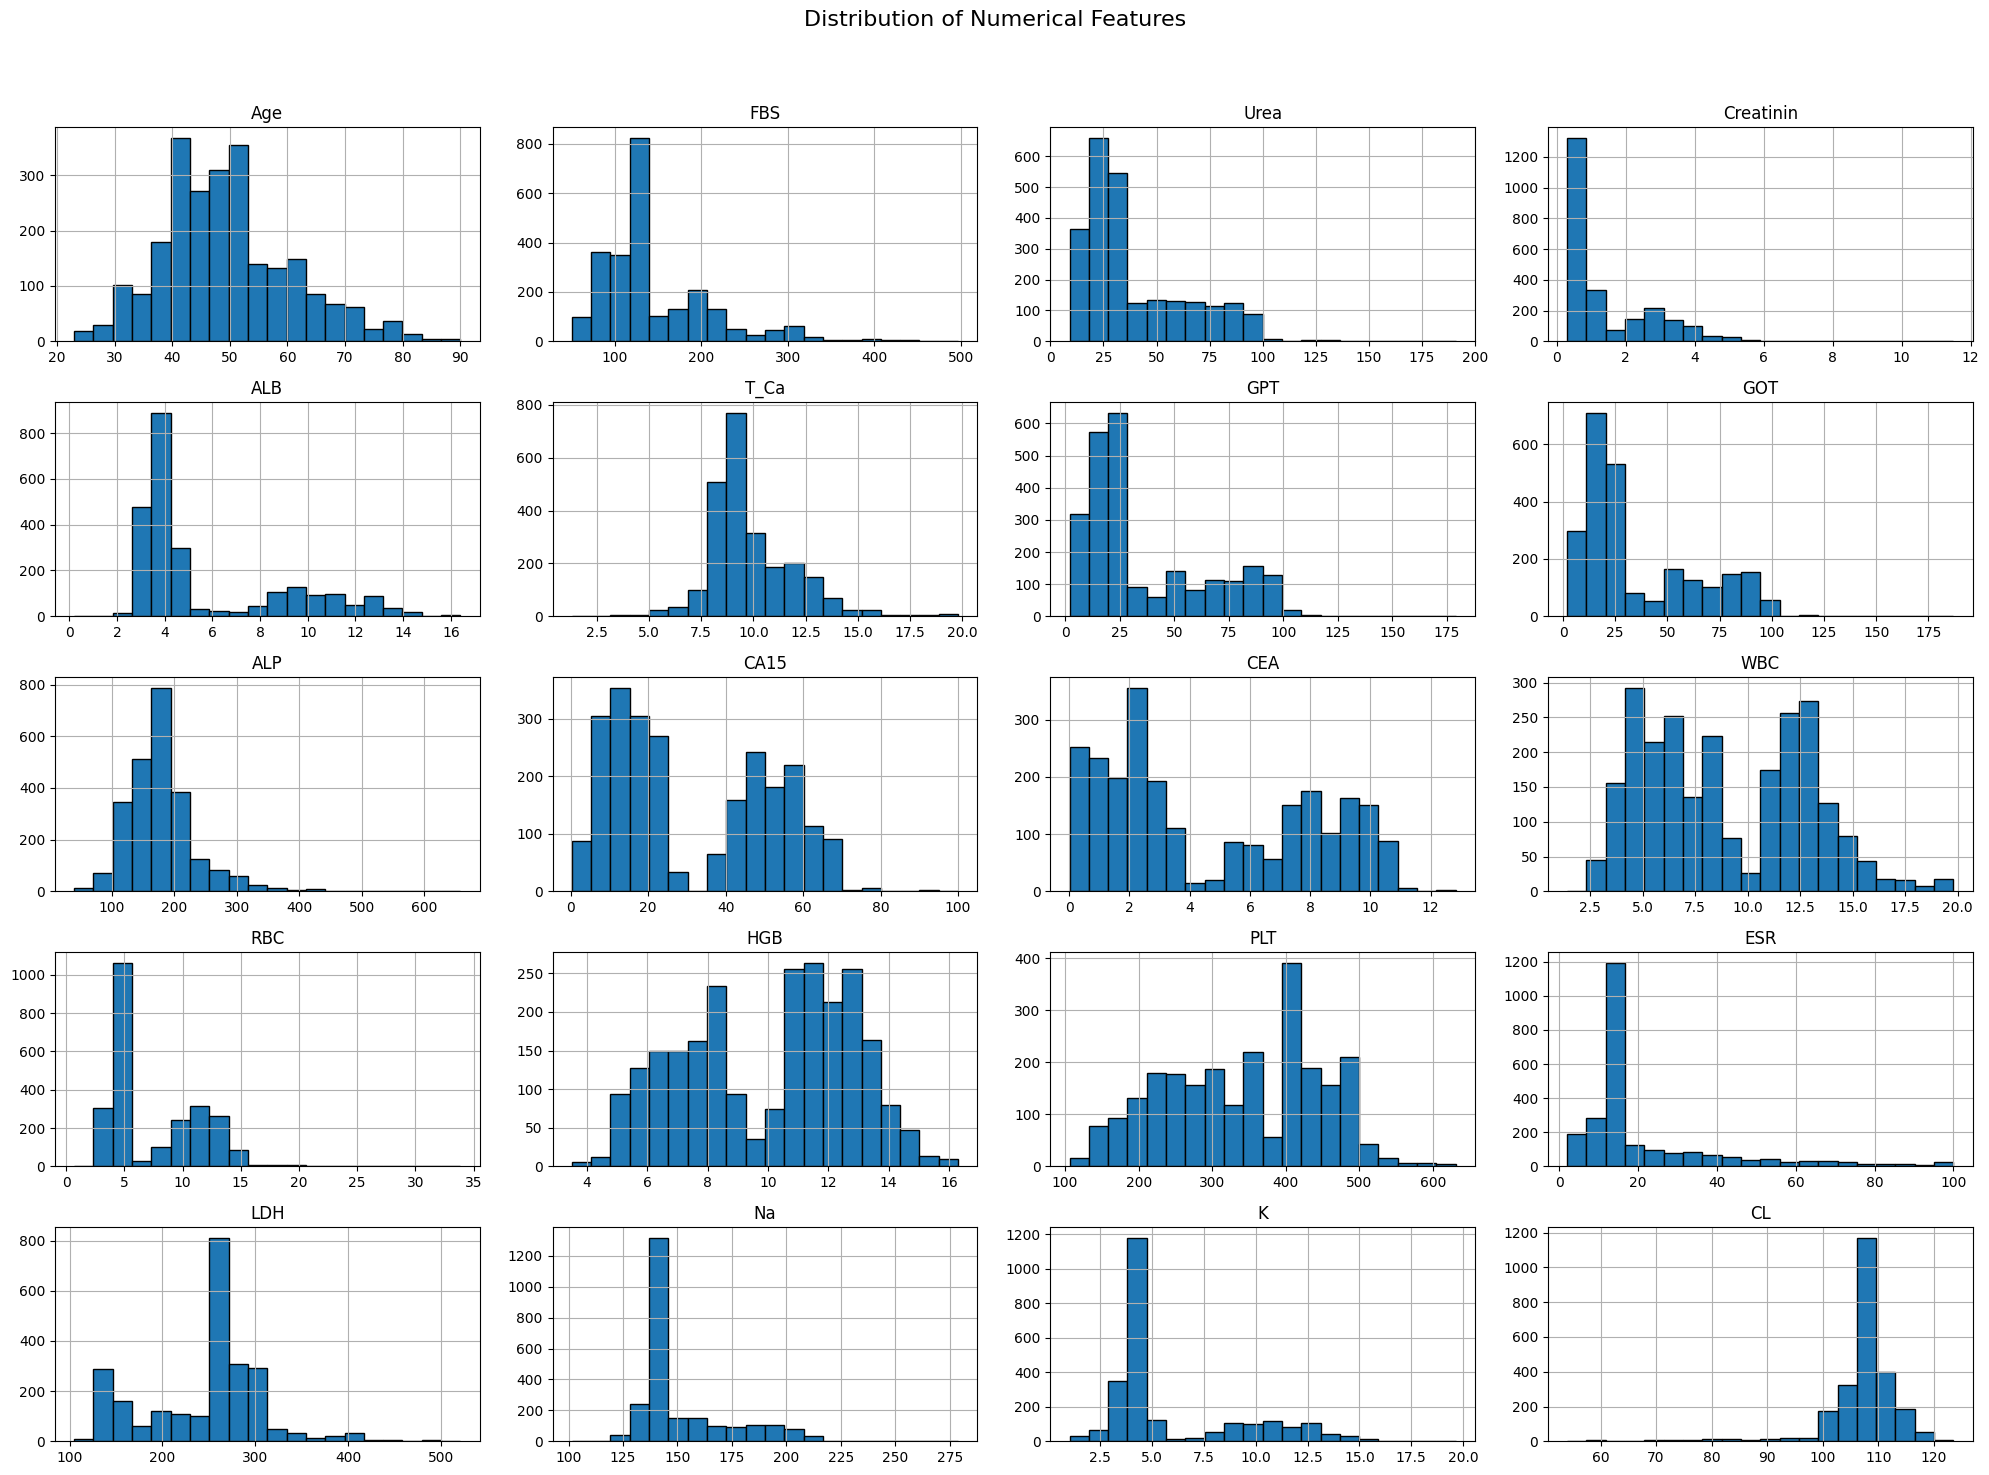

In [42]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.drop(['CLASS', 'Sex'])
data[numerical_features].hist(figsize=(20, 15), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Categorization of Variables by Type and Purpose

Categorizing the variables is essential for effectively organizing and interpreting the dataset. Dividing the variables into distinct groups (demographic, biochemical and clinical, and cancer-specific biomarkers) helps identify relevant patterns, analyze significant correlations, and structure the analysis better for predicting the target variable. This segmentation also aids in understanding the role of each variable in the medical and diagnostic context.


## Demographic and categorial variables
Adress  -  Age  -  Sex

### *Adress* 

Given the high number of sampled cities, we chose to categorize them into the three major Libian regions: Tripolitania, Cirenaica and Fezzan

In [43]:
data = data.rename(columns={'Adress': 'Address'})
data['Address'].unique()

array(['Tragan', 'Sabha', 'Obaree-center', 'Alchate', 'Morzek',
       'Alzeegan', 'Algatroon', 'Godoha', 'Zoiwela', 'OmAlrianb',
       'Tripoli', 'Wade-atebah', 'Temaciha', 'Algofra', 'Gath',
       'Benwalid', 'Temcian', 'Alzwia-Algrbia', 'Magdool', 'BenGawoad',
       'Alagialt', 'Agdabia', 'GaberOan', 'Subrath', 'ALzentan',
       'Benghazi', 'Tegee', 'Graian', 'Zwoarha', 'sabha'], dtype=object)

In [44]:
# Definizione delle regioni
Tripolitania = [
    'Tripoli', 'Benwalid', 'Subrath', 'ALzentan', 'Tegee', 'Graian', 
    'Zwoarha', 'Alagialt', 'Zoiwela'
]
Cirenaica = [
    'Benghazi', 'Agdabia', 'GaberOan', 'Alzwia-Algrbia', 'Magdool', 
    'BenGawoad', 'Alzeegan'
]
Fezzan = [
    'Sabha', 'sabha' ,'Tragan', 'Obaree-center', 'Alchate', 'Morzek', 'Algatroon', 
    'Godoha', 'OmAlrianb', 'Wade-atebah', 'Temaciha', 'Algofra', 'Gath', 'Temcian'
]

# Funzione per classificare le regioni
def classify_region_numeric(adress):
    if adress in Tripolitania:
        return 1  # Tripolitania
    elif adress in Cirenaica:
        return 2  # Cirenaica
    elif adress in Fezzan:
        return 3  # Fezzan


# Applica la funzione alla colonna 'Adress' e assicurati che il risultato sia di tipo intero
data['Address'] = data['Address'].apply(classify_region_numeric)

# Visualizza i risultati
#print(data['Adress'])

In [45]:
count_Tripolitania = len(data[(data['Address'] == 1)])
count_Cirenaica = len(data[(data['Address'] == 2)])
count_Fezzan = len(data[(data['Address'] == 3)])
print(count_Tripolitania)
print(count_Cirenaica)
print(count_Fezzan)

88
46
2301


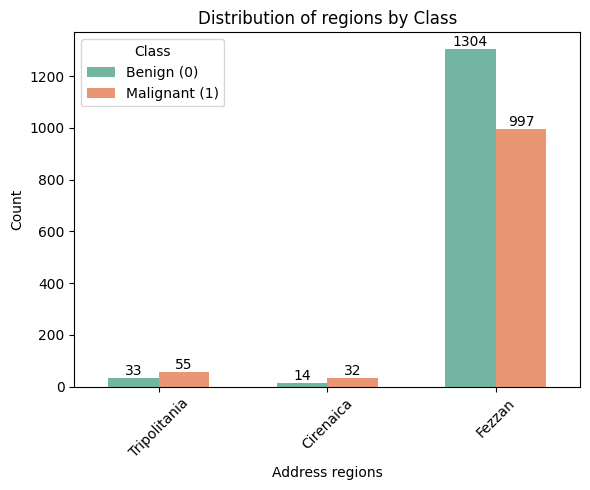

In [46]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=data, x='Address', hue='CLASS', palette='Set2', width=0.6)

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )

# Replace x-axis labels with custom names
custom_labels = ['Tripolitania', 'Cirenaica', 'Fezzan']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

plt.title('Distribution of regions by Class')
plt.xlabel('Address regions')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'], loc="upper left")
plt.tight_layout()

plt.show()

As an initial educated guess, Adress will probably have a small impact on the predictions, since almost all individuals were sampled in the same region (Fezzan)

### *Age da rivedere*

Following a similar reasoning, we also created three major age groups. The thresholds were chosen to reflect known ages brackets. Usually, the most affected individuals are women of older age.

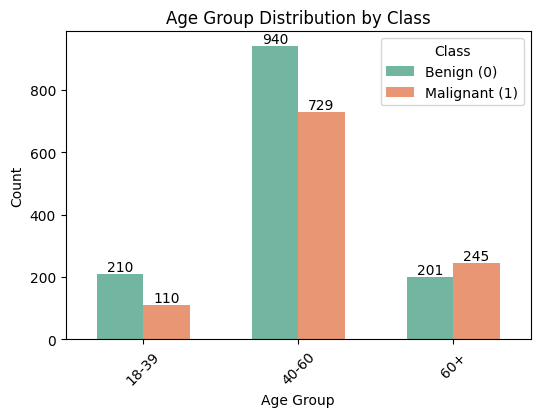

In [47]:
# Define the bins and labels
bins = [18, 39, 60, float('inf')]  # age ranges
labels = [1,2,3]  # 1=18-39, 2=40-60, 3=60+

# Categorize the ages into groups
data['Age'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# Create the grouped bar plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=data, x='Age', hue='CLASS', palette='Set2', width=0.6)  # width set to 0.6

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )
# Replace x-axis labels with custom names
custom_labels = ['18-39', '40-60', '60+']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

# Add labels and title
plt.title('Age Group Distribution by Class')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'])
plt.show()

The barplots reflect what previously mentioned. Middle-aged people were the most sampled, but breast cancer is more prevalent in individuals aged 60+

### *Sex*

We expect breast cancer to have a much larger impact on female individuals.

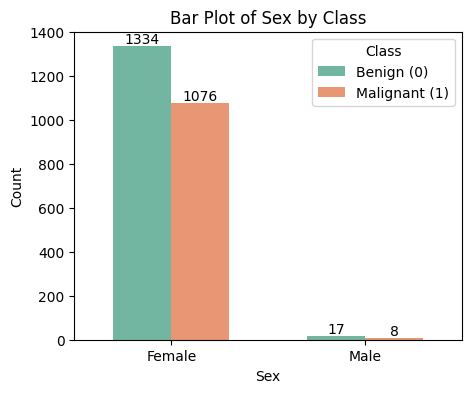

In [48]:
# Create the bar plot
plt.figure(figsize=(5, 4))
ax = sns.countplot(data=data, x='Sex', hue='CLASS', palette='Set2', width=0.6)

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )

custom_labels = ['Female', 'Male']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

# Add labels and title
plt.title('Bar Plot of Sex by Class')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'])
plt.show()

Almost all sampled individuals are females. Again, we can deduce that the Sex variable won't have much impact on the prediction.

In [49]:
count_class_0 = len(data[(data['Sex'] == 1) & (data['CLASS'] == 0)])
count_class_1 = len(data[(data['Sex'] == 1) & (data['CLASS'] == 1)])

print(count_class_0)
print(count_class_1)

print()
count_class_2 = len(data[(data['Sex'] == 2) & (data['CLASS'] == 0)])
count_class_3 = len(data[(data['Sex'] == 2) & (data['CLASS'] == 1)])
print(count_class_2)
print(count_class_3)


1334
1076

17
8


## Biochemical and Clinical Variables
FBS - Urea - Creatinin - ALB - T_Ca - GPT (ALT) - GOT (AST) - ALP - WBC - RBC - HGB - PLT - ESR - LDH - Na - K - CL

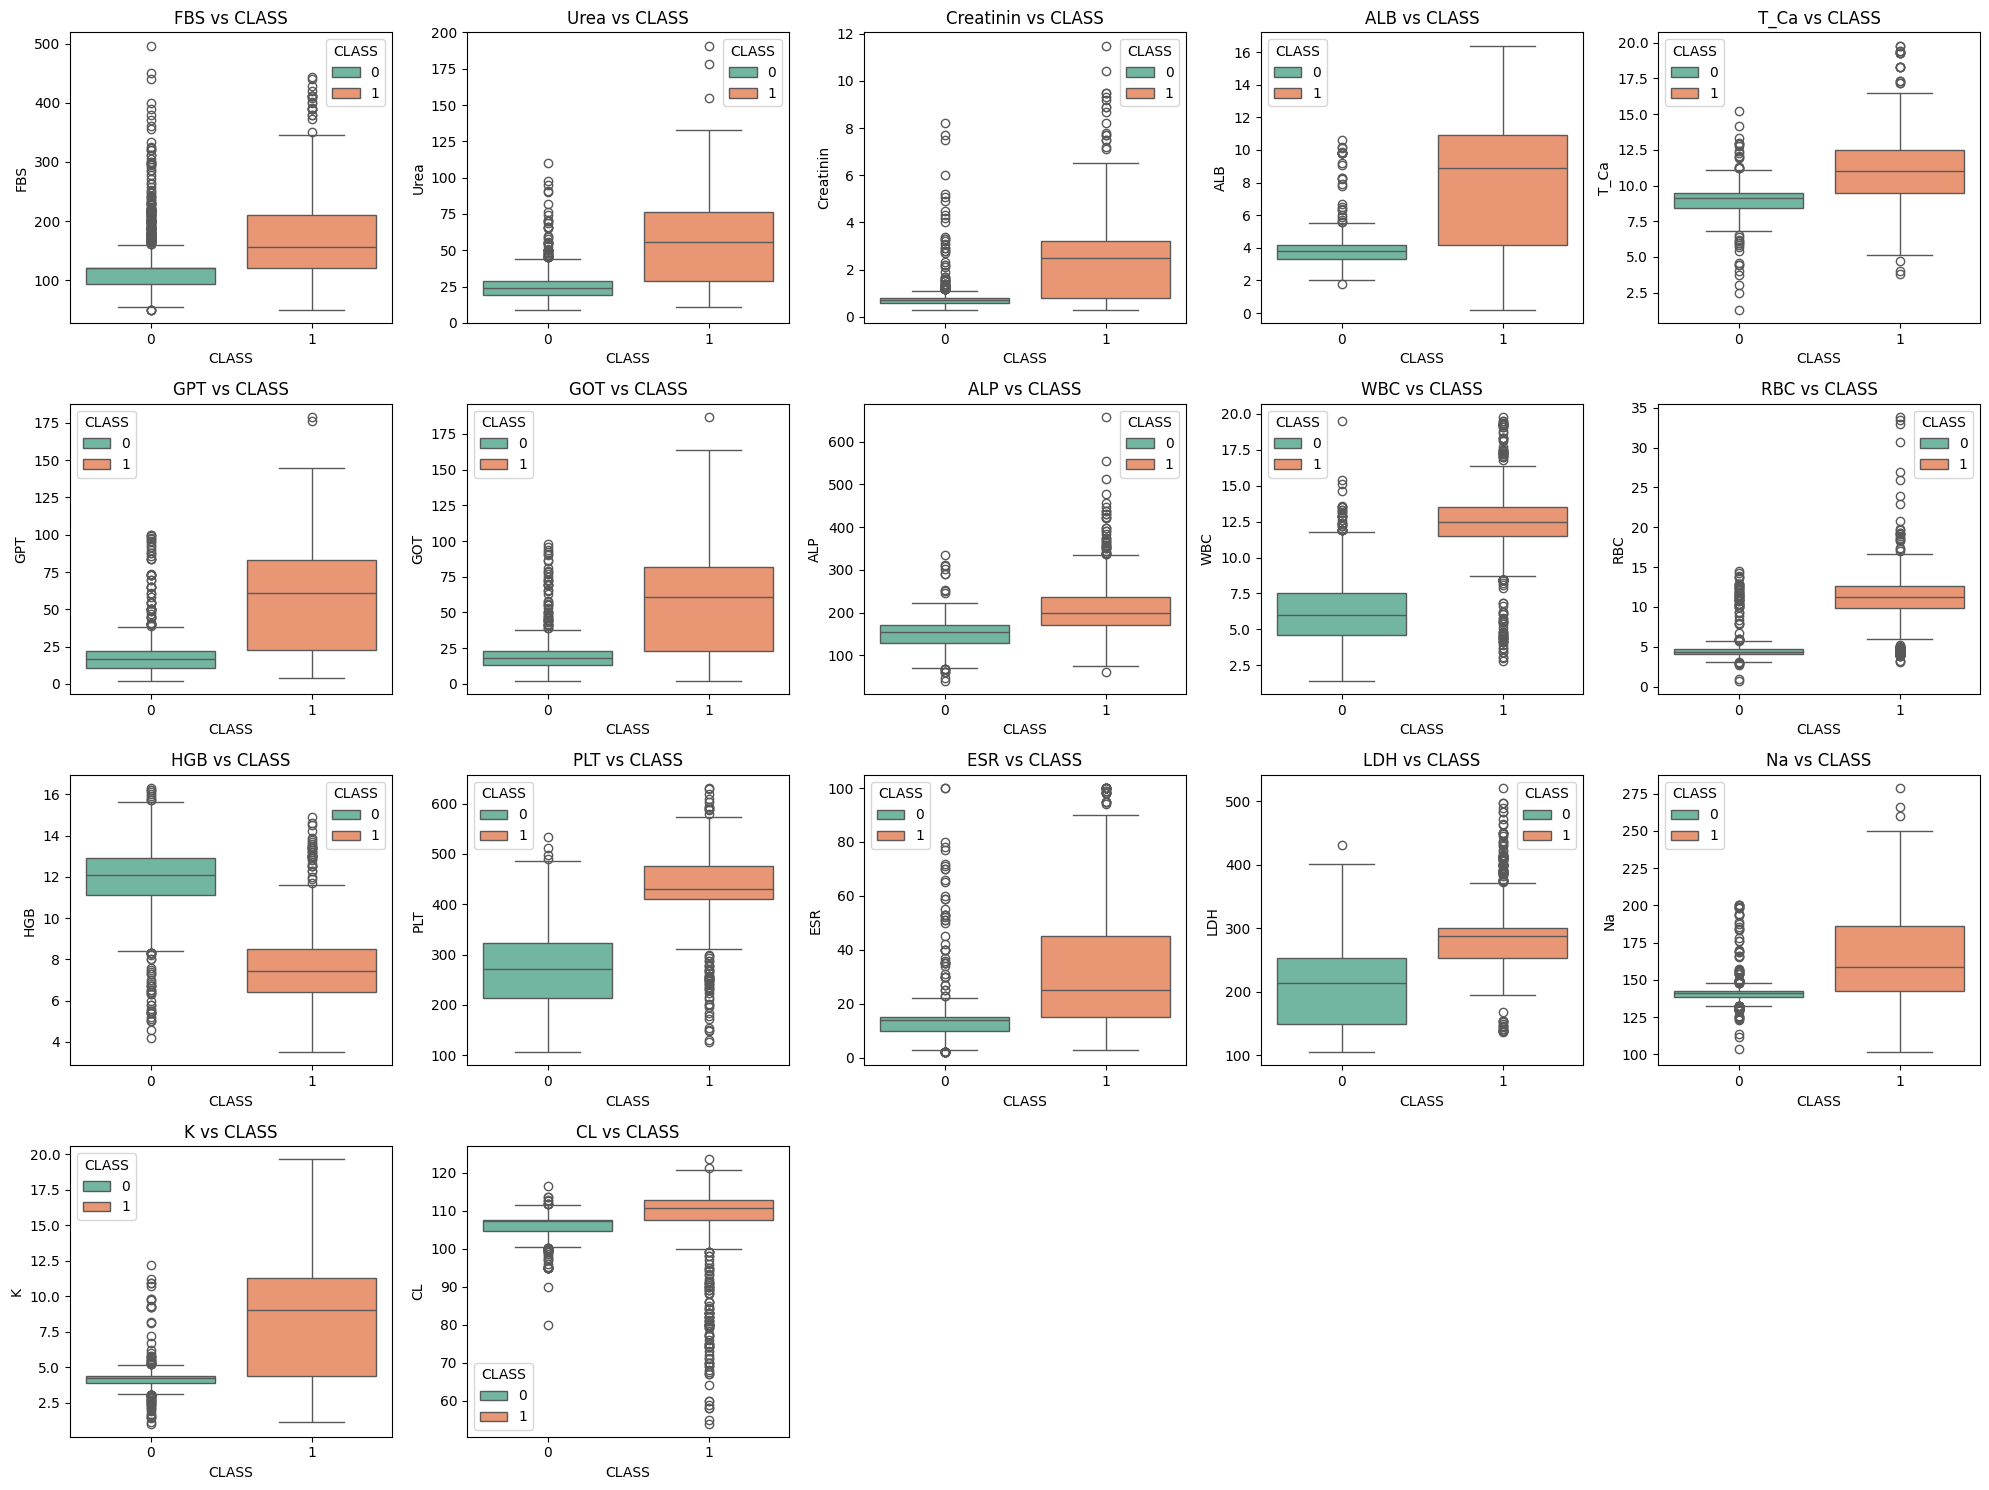

{'Correlations': CLASS        1.00000000
 RBC          0.80628465
 WBC          0.80609838
 PLT          0.75742322
 GOT          0.67476915
 GPT          0.66949497
 ALB          0.66189497
 Urea         0.62810239
 LDH          0.62630742
 K            0.60650982
 Creatinin    0.59189314
 Na           0.54704668
 ALP          0.54250407
 ESR          0.51948740
 T_Ca         0.49933431
 FBS          0.39141785
 CL           0.13949656
 HGB         -0.78914750
 Name: CLASS, dtype: float64}

In [50]:
biochemical_clinical_vars = [
    'FBS', 'Urea', 'Creatinin', 'ALB', 'T_Ca', 'GPT', 'GOT', 'ALP',
    'WBC', 'RBC', 'HGB', 'PLT', 'ESR', 'LDH', 'Na', 'K', 'CL'
]


correlations = data[biochemical_clinical_vars + ['CLASS']].corr()['CLASS'].sort_values(ascending=False)


plt.figure(figsize=(20, 15))
for i, var in enumerate(biochemical_clinical_vars, 1):
    plt.subplot(4, 5, i)
    sns.boxplot(data=data, x='CLASS', y=var, palette="Set2", hue='CLASS')
    plt.title(f'{var} vs CLASS')
    plt.xlabel('CLASS')
    plt.ylabel(var)
plt.tight_layout()
plt.show()


{
    "Correlations": correlations
}


### Results summary:

The correlation analysis reveals key insights into the relationship between biochemical and clinical variables with the target variable `CLASS` (cancer presence). Variables like **RBC**, **WBC**, and **PLT** show strong positive correlations (>0.75), suggesting that higher levels of these markers are strongly associated with cancer. Similarly, liver function enzymes such as **GOT** and **GPT**, as well as markers like **ALB**, **Urea**, and **LDH**, also demonstrate moderate to strong correlations with `CLASS`, indicating their potential relevance in cancer diagnosis.

Interestingly, **HGB** (Hemoglobin) is the only variable showing a strong negative correlation (-0.79), suggesting that lower levels are indicative of cancer presence. Other variables such as **CL** and **T_Ca** show weak correlations, indicating limited significance in differentiating between `CLASS` values.

These findings highlight the importance of blood markers and biochemical parameters in identifying cancer presence, with some variables (e.g., **RBC**, **WBC**, **PLT**) potentially serving as strong predictors for classification models. Further statistical tests and predictive modeling could refine these observations.

## Cancer Specific Biomarkers
CA15 -  CEA

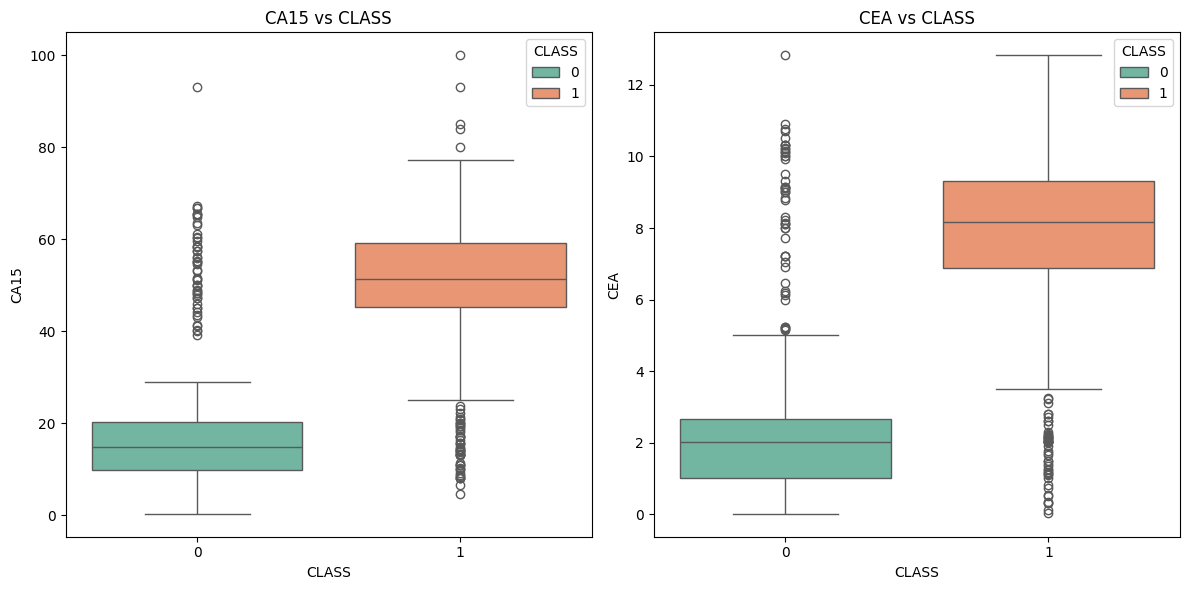

{'Correlations': CLASS   1.00000000
 CA15    0.85228827
 CEA     0.84300994
 Name: CLASS, dtype: float64}

In [51]:
cancer_biomarkers = ['CA15', 'CEA']

# 1. Correlation with CLASS
biomarker_correlations = data[cancer_biomarkers + ['CLASS']].corr()['CLASS'].sort_values(ascending=False)

# 2. Boxplot visualization for each biomarker
plt.figure(figsize=(12, 6))
for i, biomarker in enumerate(cancer_biomarkers, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=data, x='CLASS', y=biomarker, palette="Set2", hue = "CLASS")
    plt.title(f'{biomarker} vs CLASS')
    plt.xlabel('CLASS')
    plt.ylabel(biomarker)
plt.tight_layout()
plt.show()


# Results
{
    "Correlations": biomarker_correlations,
}


### Results Summary:

The correlation analysis highlights the strong relationship between cancer-specific biomarkers (**CA15** and **CEA**) and the target variable `CLASS` (cancer presence). **CA15** shows a very high positive correlation (**0.85**), indicating its effectiveness as a diagnostic marker, particularly for breast cancer. Similarly, **CEA** demonstrates a strong positive correlation (**0.84**), reinforcing its role as a versatile biomarker for various types of cancer.

These findings emphasize the critical importance of **CA15** and **CEA** in identifying cancer presence and their potential as primary predictors in diagnostic models. Further analysis and validation could enhance their utility in clinical applications.

## Correlation Matrix

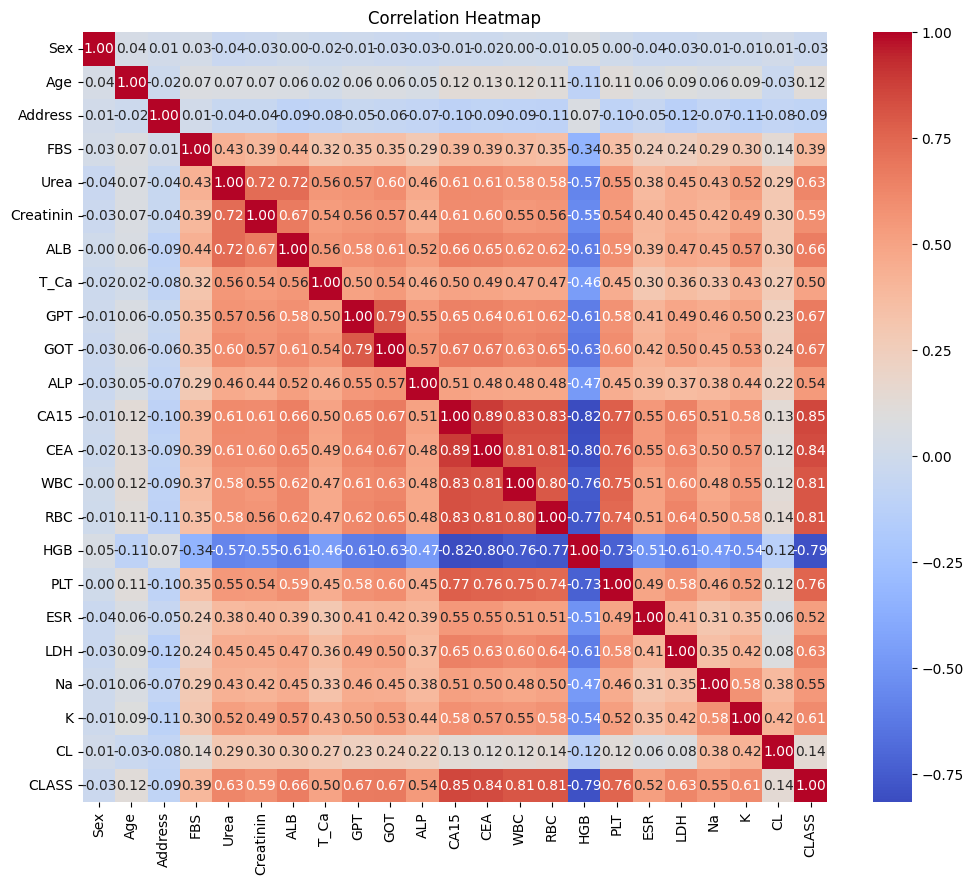

In [52]:
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

### bisogna dire tipo come nelle analisi precendi eccc
Studies show that biomarkers such as CA15 and CEA -link- are already established and well known predictors of benign and malign cancer, and this correlation matrix shows problems in the sense that these two variables re highly correlated with each other, shadowing the effect of other predictors. For this reason we chose to focus our attention towards such predictors.

We begin by removing CA15, since is shows the highest levels of correlation




The correlation heatmap reveals various relationships between variables. Strong correlations exist between biomarkers like **CA15**, **CEA**, **RBC**, and **WBC**, suggesting they are related and may reflect similar physiological processes. Conversely, **CL** and **Na** show weak correlations with most other variables, indicating limited relevance. **HGB** displays a strong negative correlation with others, highlighting distinct relationships. Additionally, **Age**, **Sex**, and **Adress** show weak or no significant correlations with most features, suggesting they might not contribute strongly to the variability in the dataset or the target variable, **CLASS**. These findings highlight the importance of focusing on key biomarkers for further analysis.

## Variance Inflation Factor

In [53]:
# Add a constant (intercept) column to the dataset for calculating VIF
features_const = sm.add_constant(data[['PLT', 'GPT', 'WBC', 'K', 'HGB', 'RBC', 'ALP', 'Na', 'CL', 'Urea']])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = features_const.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features_const.values, i) for i in range(features_const.shape[1])]

# Display the results
print(vif_data)


   Feature          VIF
0    const 420.59396032
1      PLT   2.89728142
2      GPT   2.14288928
3      WBC   3.64034575
4        K   2.14242624
5      HGB   3.18024669
6      RBC   3.73868200
7      ALP   1.58809368
8       Na   1.74229885
9       CL   1.38470730
10    Urea   1.92371786


CEA shows a VIF value just above the problematic threshold. We chose not to include it because as we've seen before, it is one of the two (uninteresting) biormarkers.

Multicollinearity does not affect the predictive power of the model but makes it difficult to interpret the individual coefficients of the predictors.

We will now proceed with feature selection on the remaining variables.

# Selection, Description and possibly comparison of the most suitable statistical models

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score
import numpy as np

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [55]:
# Split the dataset into features and target
X = data.drop(columns=['CLASS', 'CA15', 'CEA'])
y = data['CLASS']

#print(X)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=61)

# Forward selection

In [56]:
# Forward Selection Function
def forward_selection(X, y):
    initial_features = X.columns.tolist()
    selected_features = []
    while initial_features:
        remaining_features = list(set(initial_features) - set(selected_features))
        new_pval = pd.Series(index=remaining_features, dtype=float)

        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [feature]])).fit()
            new_pval[feature] = model.pvalues[feature]
        
        min_pval = new_pval.min()
        if min_pval < 0.001:  # Set significance level
            selected_features.append(new_pval.idxmin())
        else:
            break

    return selected_features

selected_features = forward_selection(X, y)
print("Selected features:", selected_features)


Selected features: ['PLT', 'RBC', 'WBC', 'HGB', 'GPT', 'Na', 'Urea', 'ALP', 'CL', 'K', 'LDH']


CEA e CA15 sono importanti perche xyz link jack e decidiamo di rimuoverli perche abc + evidenziamo i problemi di VIF $\\$


proviamo a fare un modello con solo quelle

(modello logistico rapido come ulteriore giustificazione)

### Logistic Regression with all variables (except CEA and CA15)

In [57]:
'''# Set the float format to display more decimals
# pd.set_option("display.float_format", lambda x: f"{x:.8f}")
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Add a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the logistic regression model
log_reg = sm.Logit(y_train, X_train_const).fit()

# Predictions
y_pred = log_reg.predict(X_test_const)
y_pred = np.round(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(log_reg.summary())
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)'''

'# Set the float format to display more decimals\n# pd.set_option("display.float_format", lambda x: f"{x:.8f}")\npd.set_option(\'display.float_format\', lambda x: \'%.8f\' % x)\n\n# Add a constant to the model (intercept)\nX_train_const = sm.add_constant(X_train)\nX_test_const = sm.add_constant(X_test)\n\n# Fit the logistic regression model\nlog_reg = sm.Logit(y_train, X_train_const).fit()\n\n# Predictions\ny_pred = log_reg.predict(X_test_const)\ny_pred = np.round(y_pred)\n\n# Evaluate the model\naccuracy = accuracy_score(y_test, y_pred)\nconf_matrix = confusion_matrix(y_test, y_pred)\n\nprint(log_reg.summary())\nprint("Accuracy:", accuracy)\nprint("\nConfusion Matrix:\n", conf_matrix)'

# AUC feature selection

In [58]:
def auc_selection(X):
  features = list(X.columns)
  # features.remove("CA15")

  X_const = sm.add_constant(X_train)
  selected_features = []

  best_auc = 0
  max_iteration = len(features)

  for _ in range(0,max_iteration):
    aucs = []
    for feature_2 in features:
      features_to_use = [*selected_features, feature_2]
      log_reg_sm = sm.Logit(y_train, X_const[features_to_use]).fit(disp=0)
      y_train_pred = log_reg_sm.predict(X_const[features_to_use])
      auc = roc_auc_score(y_train, y_train_pred)
      aucs.append(auc)
      
    if max(aucs) - best_auc > 0.001:
      best_feature = aucs.index(max(aucs))
      selected_features.append(features[best_feature])
      best_auc = max(aucs)
      features.remove(features[best_feature])
    
    aucs = []
    
  return selected_features

def accuracy_selection(X, y):
  initial_features = X.columns.tolist()
  selected_features = []
  best_accuracy = 0
  max_iteration = len(initial_features)

  for _ in range(max_iteration):
    accuracies = []
    for feature in initial_features:
      features_to_use = selected_features + [feature]
      X_train_const = sm.add_constant(X[features_to_use])
      log_reg_sm = sm.Logit(y, X_train_const).fit(disp=0)
      y_pred = log_reg_sm.predict(X_train_const)
      accuracy = accuracy_score(y, np.round(y_pred))
      accuracies.append(accuracy)
    
    if max(accuracies) - best_accuracy > 0.001:
      best_feature = initial_features[accuracies.index(max(accuracies))]
      selected_features.append(best_feature)
      best_accuracy = max(accuracies)
      initial_features.remove(best_feature)
    else:
      break

  return selected_features

selected_features_auc = auc_selection(X_train)
selected_features_accuracy = accuracy_selection(X_train, y_train)
print("Selected features based on auc:", selected_features_auc)
print("Selected features based on accuracy:", selected_features_accuracy)


Selected features based on auc: ['WBC', 'HGB', 'GPT', 'Na', 'CL', 'K', 'ALP', 'ALB']
Selected features based on accuracy: ['RBC', 'HGB', 'Na', 'WBC', 'Urea']


# Feature selection w/ Random Forest

### TO-DO

Aggregated Feature Importances over 100 iterations:
           Importance     StdDev
RBC        0.20744520 0.03587046
WBC        0.18114929 0.02913140
PLT        0.13904287 0.03312578
HGB        0.12373619 0.02666868
Na         0.05764343 0.01193193
GPT        0.05601251 0.01411621
Creatinin  0.05187596 0.01515513
GOT        0.05167975 0.01695024
LDH        0.02747788 0.01144282
ALP        0.02420376 0.00740934
ALB        0.02144795 0.00973684
K          0.01955370 0.00808075
Urea       0.01760815 0.00987793
ESR        0.00955577 0.00445946
CL         0.00616297 0.00213985
T_Ca       0.00386436 0.00256578
FBS        0.00127548 0.00037640
Age        0.00025122 0.00011741
Address    0.00001316 0.00002067
Sex        0.00000040 0.00000397


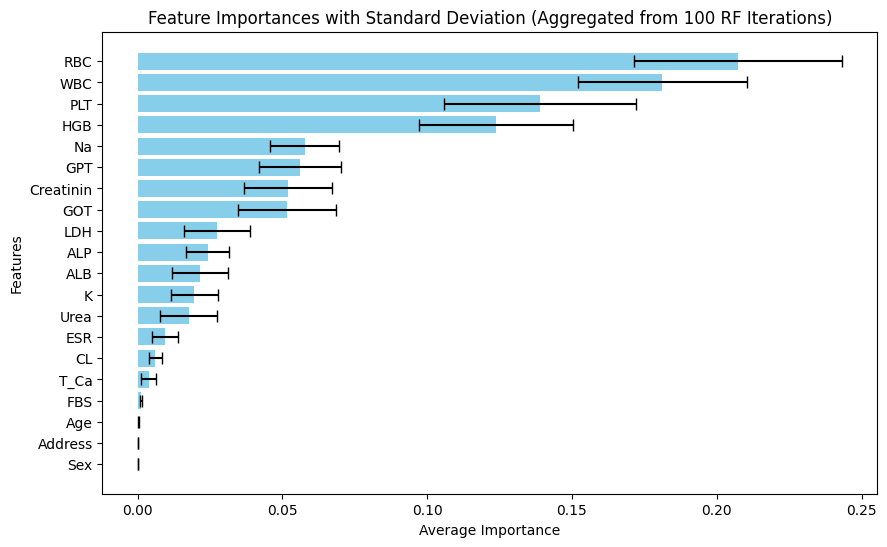

In [59]:
# Initialize a dictionary to store feature importances across iterations
importances_over_iterations = {column: [] for column in X.columns}

# Perform 100 iterations of training and evaluation
for _ in range(100):
    # Split the dataset into train and test subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(max_depth=4, random_state=None)
    rf_model.fit(X_train, y_train)

    # Predictions and evaluation
    y_pred_rf = rf_model.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

    # Collect feature importances
    importances = rf_model.feature_importances_
    for feature, importance in zip(X.columns, importances):
        importances_over_iterations[feature].append(importance)

# Compute average importance and standard deviation for each feature
average_importances = {feature: np.mean(importances) for feature, importances in importances_over_iterations.items()}
std_importances = {feature: np.std(importances) for feature, importances in importances_over_iterations.items()}

# Convert the results into a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Importance': average_importances,
    'StdDev': std_importances
}).sort_values(by='Importance', ascending=False)

# Display the final aggregated importance values with standard deviation
print("Aggregated Feature Importances over 100 iterations:")
print(importance_df)

# Visualizing feature importances with error bars (standard deviation)
plt.figure(figsize=(10, 6))
plt.barh(importance_df.index, importance_df['Importance'], xerr=importance_df['StdDev'], capsize=4, color='skyblue')
plt.xlabel('Average Importance')
plt.ylabel('Features')
plt.title('Feature Importances with Standard Deviation (Aggregated from 100 RF Iterations)')
plt.gca().invert_yaxis()
plt.show()


# Logistic Regression after random forest (selection)

In [60]:
X = data[['WBC', 'PLT', 'RBC', 'HGB', 'GPT']]
y = data['CLASS']

#print(X)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [61]:
# Add a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the logistic regression model
log_reg = sm.Logit(y_train, X_train_const).fit()

# Extract p-values and coefficients with more decimals
summary_frame = log_reg.summary2().tables[1]  # Extract the coefficient table
summary_frame["P>|z|"] = summary_frame["P>|z|"].apply(lambda x: f"{x:.8f}")  # Format p-values
summary_frame["Coef."] = summary_frame["Coef."].apply(lambda x: f"{x:.8f}")  # Format coefficients

# Print the adjusted summary table
print(summary_frame)

# Predictions
y_pred = log_reg.predict(X_test_const)
y_pred = np.round(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)


Optimization terminated successfully.
         Current function value: 0.195496
         Iterations 8
             Coef.   Std.Err.           z       P>|z|      [0.025      0.975]
const  -5.44237051 1.11402648 -4.88531522  0.00000103 -7.62582229 -3.25891874
WBC     0.27299246 0.05182983  5.26709210  0.00000014  0.17140787  0.37457706
PLT     0.00485686 0.00170419  2.84995381  0.00437256  0.00151671  0.00819701
RBC     0.23378234 0.05312065  4.40096913  0.00001078  0.12966778  0.33789691
HGB    -0.17211992 0.06269634 -2.74529474  0.00604566 -0.29500248 -0.04923736
GPT     0.03132611 0.00481782  6.50213508  0.00000000  0.02188336  0.04076886
Accuracy: 0.9630390143737166

Confusion Matrix:
 [[275   8]
 [ 10 194]]


## Ridge Classifier

In [62]:
from sklearn.linear_model import RidgeClassifier

# Initialize and train the model
ridge_model = RidgeClassifier()
ridge_model.fit(X_train, y_train)

# Predictions
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the model
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
conf_matrix_ridge = confusion_matrix(y_test, y_pred_ridge)

print("Accuracy:", accuracy_ridge)

print("\nConfusion Matrix:\n", conf_matrix_ridge)


Accuracy: 0.9589322381930184

Confusion Matrix:
 [[275   8]
 [ 12 192]]


## Results

# Grafici e alberi se si vuole far vedere se no si toglie

IndexError: index 11 is out of bounds for axis 0 with size 5

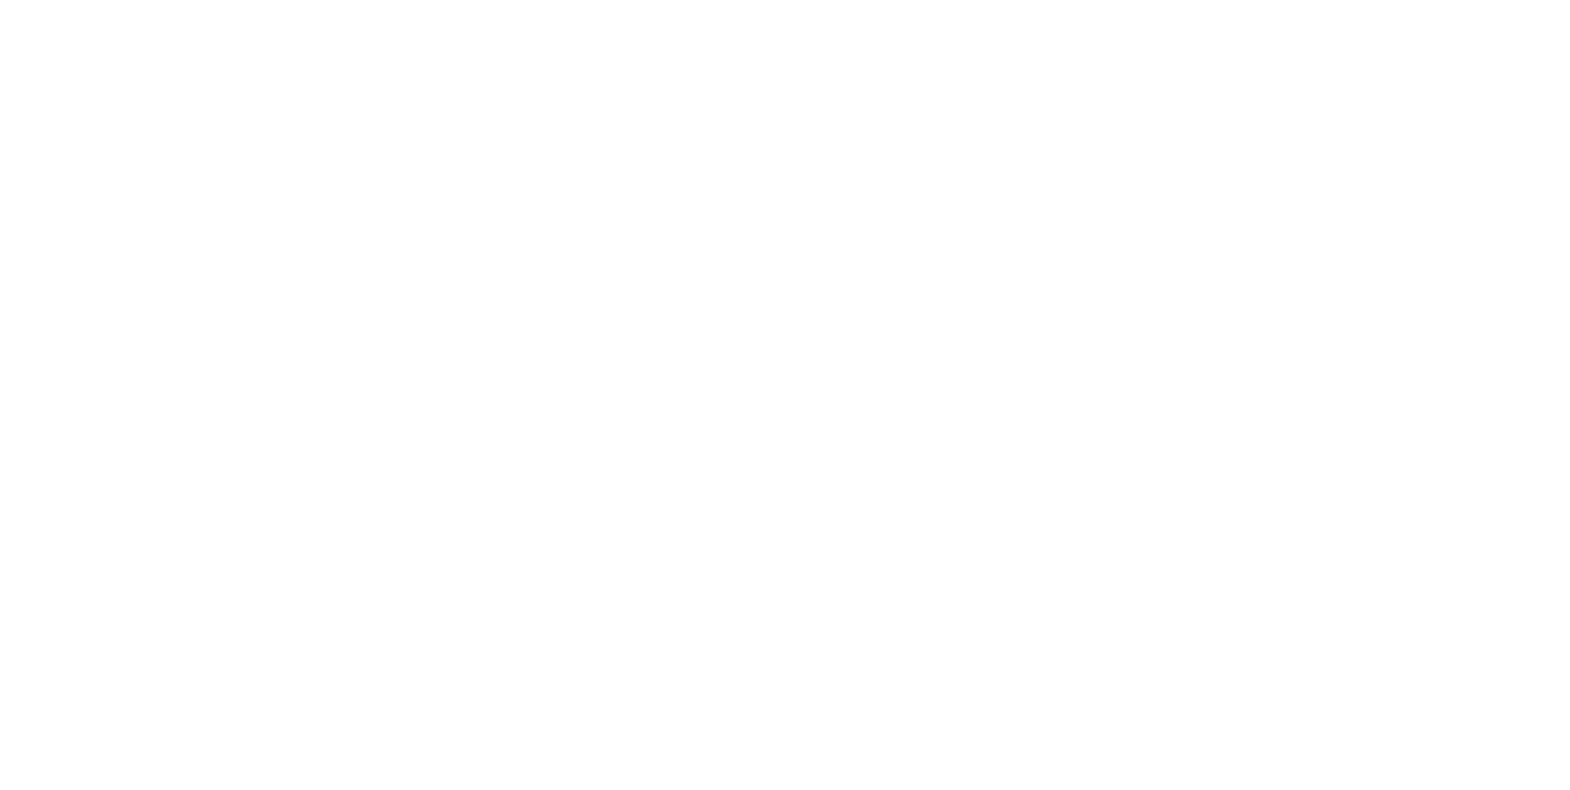

In [63]:
tree_rf = rf_model.estimators_[61]


# Visualizing the Decision Tree with only feature names and class labels, excluding other details
plt.figure(figsize=(20, 10))
plot_tree(tree_rf, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Benign', 'Malignant'],  
          label='none',  
          impurity=False,  
          proportion=False,  
          node_ids=False, 
          fontsize=12)
plt.title("Random Forest - Visualizing One Tree")
plt.show()

# GAM   Grandi smeni, smeni duri cazzi amari cazzi in golas

da capire le librerie gam su python


# Comments on results